In [8]:
# 导入模块
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [4]:
# 读取数据
camEdge = pd.read_excel("../附件/附件1-凸轮边缘曲线.xlsx") # 读取凸轮边缘曲线数据
valve = pd.read_excel("../附件/附件2-针阀运动曲线.xlsx")  # 读取针阀运动曲线数据
elastic = pd.read_excel("../附件/附件3-弹性模量与压力.xlsx")  # 读取弹性模量与压力数据

Text(0.5, 1.0, '凸轮边缘曲线')

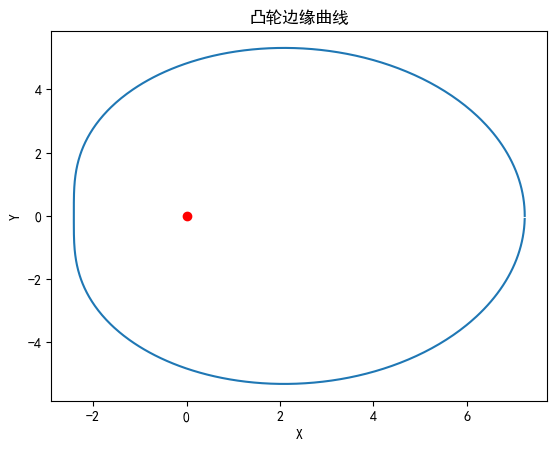

In [19]:
#% 绘图

# 绘制凸轮边缘曲线
plt.plot(camEdge['X'],camEdge['Y'], label='凸轮边缘曲线') # 绘制凸轮边缘曲线
plt.scatter(0,0, color='red', label='中心点') # 绘制中心点
plt.xlabel('X') # 设置X轴标签
plt.ylabel('Y') # 设置Y轴标签
plt.title('凸轮边缘曲线') # 设置标题


Text(0.5, 1.0, '针阀运动曲线')

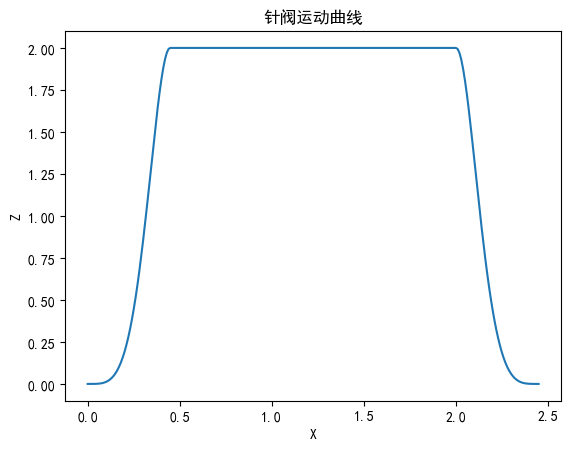

In [18]:
# 绘制针阀运动曲线
plt.plot(valve['时间(ms)'],valve['距离(mm)'], label='针阀运动曲线') # 绘制针阀运动曲线
plt.xlabel('时间(ms)') # 设置X轴标签
plt.ylabel('距离(mm)') # 设置Y轴标签
plt.title('针阀运动曲线') # 设置标题